In [1]:
!pip install -q python-igraph scikit-learn ripser persim

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.3/841.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.0 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")

# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 342kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.41MB/s]


Total number of '1' images in the training set: 6742
Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [3]:
# k = 10, 20, 40

In [4]:
from sklearn.neighbors import NearestNeighbors

distances, indices = NearestNeighbors(n_neighbors=3).fit(unique_vectors).kneighbors(unique_vectors)

In [5]:
import torch
import numpy as np

def compute_final_value(unique_vectors, distances, num_samples=200):
    """
    Computes the final value based on randomly sampled vectors.

    For num_samples randomly selected indices from unique_vectors,
    this function calculates the ratio between the 3rd neighbor distance (d3)
    and the 2nd neighbor distance (d2), then:
      - Takes the base-2 logarithm of each ratio.
      - Averages these log2 values.
      - Returns the reciprocal of this average.

    Parameters:
        unique_vectors (torch.Tensor): Tensor of unique flattened MNIST images.
        distances (np.ndarray): Precomputed distances array from NearestNeighbors
                                (expected shape: [N, 3]).
        num_samples (int): Number of samples to randomly select (default is 200).

    Returns:
        final_value (float): The computed value (1 / average log2 ratio).
    """
    # Randomly select indices from the available unique_vectors
    selected_idxs = torch.randperm(unique_vectors.shape[0])[:num_samples].numpy()

    # Extract the distances for the selected samples
    selected_distances = distances[selected_idxs]

    # For each sample, the first neighbor is itself (distance 0).
    # So we use:
    #   - Column index 1: distance to the 2nd neighbor
    #   - Column index 2: distance to the 3rd neighbor
    d2 = selected_distances[:, 1]
    d3 = selected_distances[:, 2]

    # Compute the ratio of the 3rd neighbor distance to the 2nd neighbor distance
    ratios = d3 / d2

    # Take the base-2 logarithm of the ratios
    log2_ratios = np.log(ratios)

    # Compute the average of these log2 values
    average_log2 = np.mean(log2_ratios)

    # The final computed number is the reciprocal of the average log2 value
    final_value = 1 / average_log2

    return final_value

# Example usage:
final_number = compute_final_value(unique_vectors, distances, num_samples=200)
print("Final computed number (1 / average log2 ratio):", final_number)


Final computed number (1 / average log2 ratio): 14.652407790977033


For num_samples = 400, final computed value: 13.581578507104124
For num_samples = 800, final computed value: 12.576168479607887
For num_samples = 1600, final computed value: 13.245529379076666
For num_samples = 6787, final computed value: 12.976801492669773


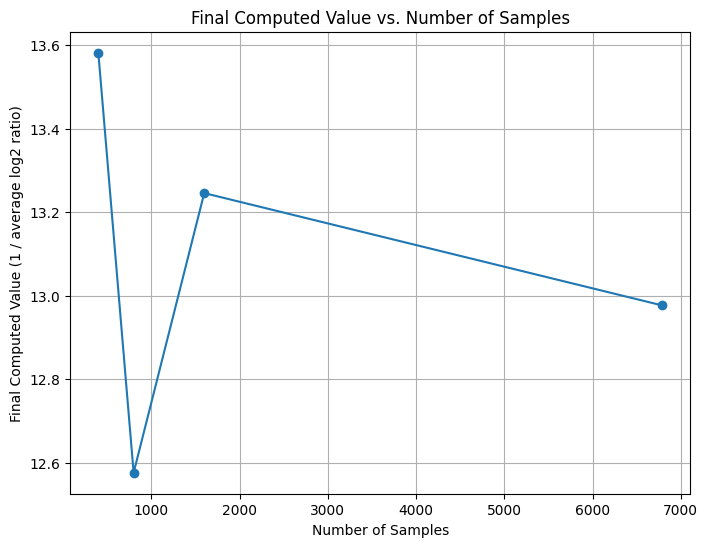

In [6]:
sample_sizes = [400, 800, 1600, 6787]
final_values = []

for n in sample_sizes:
    fv = compute_final_value(unique_vectors, distances, num_samples=n)
    final_values.append(fv)
    print(f"For num_samples = {n}, final computed value: {fv}")

# Plotting the results:
plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, final_values, marker='o')
plt.xlabel("Number of Samples")
plt.ylabel("Final Computed Value (1 / average log2 ratio)")
plt.title("Final Computed Value vs. Number of Samples")
plt.grid(True)
plt.show()

Estimated d̂: 12.98


<ipython-input-7-27c8b9f1e6ea>:43: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  integral_fit = np.trapz(fitted_curve, mu_vals)


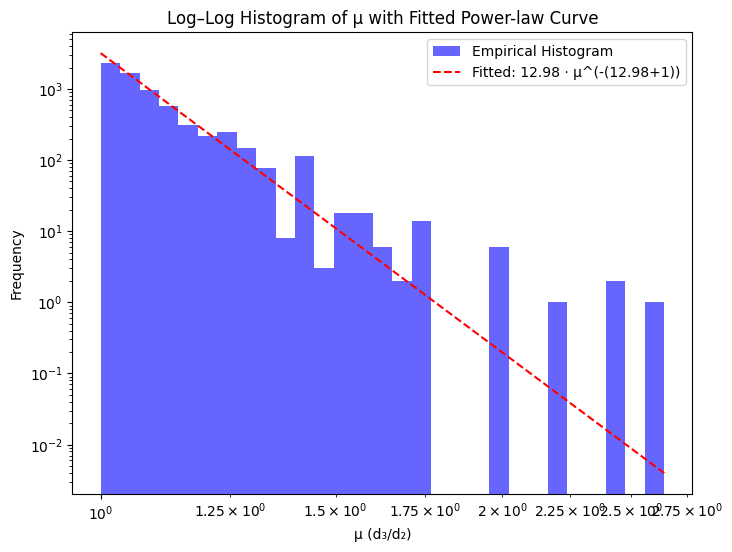

In [7]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Use the largest sample: num_samples = 6000
num_samples = 7000
selected_idxs = torch.randperm(unique_vectors.shape[0])[:num_samples].numpy()
selected_distances = distances[selected_idxs]

# Get distances to the 2nd and 3rd nearest neighbors
d2 = selected_distances[:, 1]
d3 = selected_distances[:, 2]

# μ is the ratio of the 3rd neighbor distance to the 2nd neighbor distance
mu = d3 / d2

# Estimate d̂ using the same method as before
# (we use log base 2 as in the previous computation)
d_hat = 1 / np.mean(np.log(mu))
print(f"Estimated d̂: {d_hat:.2f}")

# Plot histogram of μ on a log-log axis
plt.figure(figsize=(8,6))
# Create logarithmically spaced bins across the observed range of μ
bins = np.logspace(np.log10(mu.min()), np.log10(mu.max()), 30)
counts, bin_edges, _ = plt.hist(mu, bins=bins, alpha=0.6, color='b', label="Empirical Histogram")

# Set log scales for both axes
plt.xscale('log')
plt.yscale('log')

# Generate a range of μ values for the fitted curve
mu_vals = np.logspace(np.log10(mu.min()), np.log10(mu.max()), 100)
# Fitted power-law density: d̂ · μ^{-(d̂+1)}
fitted_curve = d_hat * mu_vals**(-(d_hat+1))

# The histogram has counts (not a probability density), so we need to scale
# the fitted curve so that its integral matches the histogram area.
# Compute the area under the histogram.
bin_widths = np.diff(bin_edges)
hist_area = np.sum(counts * bin_widths)
# Compute the integral of the fitted curve using the trapezoidal rule.
integral_fit = np.trapz(fitted_curve, mu_vals)
# Scale the fitted curve accordingly.
scale_factor = hist_area / integral_fit
fitted_scaled = fitted_curve * scale_factor

# Overlay the fitted curve.
plt.plot(mu_vals, fitted_scaled, 'r--', label=f'Fitted: {d_hat:.2f} · μ^(-({d_hat:.2f}+1))')

plt.xlabel("μ (d₃/d₂)")
plt.ylabel("Frequency")
plt.title("Log–Log Histogram of μ with Fitted Power-law Curve")
plt.legend()
plt.show()


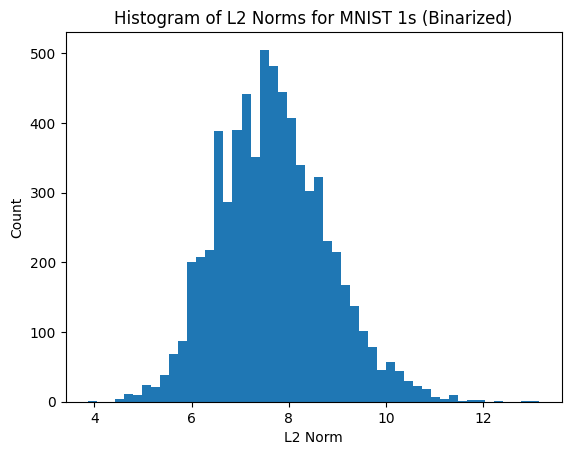

In [8]:
# Compute L2 norms
norms = unique_vectors.norm(dim=1).numpy()

# Plot
plt.hist(norms, bins=50)
plt.xlabel('L2 Norm')
plt.ylabel('Count')
plt.title('Histogram of L2 Norms for MNIST 1s (Binarized)')
plt.show()

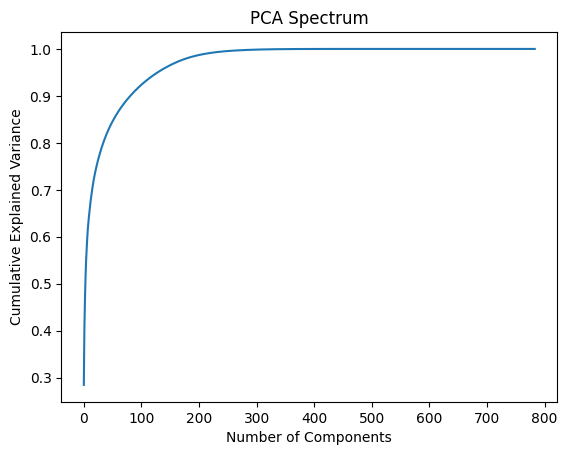

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(unique_vectors)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Spectrum')
plt.show()


In [10]:
from sklearn.neighbors import NearestNeighbors
from scipy.stats import linregress
import numpy as np

k = 10  # or try 5-15

nbrs = NearestNeighbors(n_neighbors=k+1).fit(unique_vectors)
distances, _ = nbrs.kneighbors(unique_vectors)

# Skip the first distance (distance to self = 0)
log_ratios = np.log(distances[:, k] / distances[:, 1])
mle_id = (k - 2) / np.sum(log_ratios) * unique_vectors.shape[0]

print(f"MLE Estimated Intrinsic Dimension: {mle_id:.2f}")


MLE Estimated Intrinsic Dimension: 35.44
